In [74]:
import jammy_flows
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import DataLoader, IterableDataset, random_split
from torch.optim import Adam 
import math
import pandas as pd
import numpy as np

In [94]:
class HDF5PhotonTable(IterableDataset):
    def __init__(self, filename, start, end):
        super(HDF5PhotonTable).__init__()
        assert end > start, "end >= start"
        self._hdl = h5py.File(filename)
        self.size = len(self._hdl["photon_tables"].keys())
        self.start = start
        self.end = min((self.size, end)) 

    def __len__(self):
        return self.size

    def __iter__(self):
        worker_info = torch.utils.data.get_worker_info()
        if worker_info is None:  # single-process data loading, return the full iterator
            iter_start = self.start
            iter_end = self.end
        else:  # in a worker process
            # split workload
            per_worker = int(math.ceil((self.end - self.start) / float(worker_info.num_workers)))
            worker_id = worker_info.id
            iter_start = self.start + worker_id * per_worker
            iter_end = min(iter_start + per_worker, self.end)

        ds_groups = sorted(self._hdl["photon_tables"].keys())

        for i in range(iter_start, iter_end):
            grp = ds_groups[i]
            labels_d = dict(self._hdl["photon_tables"][grp].attrs)
            label_order = ["distance", "energy", "dir_theta", "dir_phi", "pos_theta", "pos_phi"]
            labels = [labels_d[label] for label in label_order]

            data = self._hdl["photon_tables"][grp][:].T

            df = pd.DataFrame(
                data=data,
                columns=["pmt_id", "time"],
                )     
            
            yield [df.loc[df["pmt_id"] == i, "time"].values for i in range(1, 17)], labels
       
    def __del__(self):
        if hasattr(self, "_hdl"):
            self._hdl.close()
        

def collate_fn(batch):
    data = [item[0] for item in batch]
    labels = [item[1] for item in batch]
    labels = torch.FloatTensor(labels)
    return [data, labels]
        

In [101]:
training_data = HDF5PhotonTable("../assets/photon_table.hd5", 0, 70)


In [102]:
training_data = HDF5PhotonTable("../assets/photon_table.hd5", 0, 70)
test_data = HDF5PhotonTable("../assets/photon_table.hd5", 70, 100)


#train_dl =  DataLoader(training_data, batch_size=64, collate_fn=collate_fn)
pdf = jammy_flows.pdf("e1", "gggg")
optim = Adam(pdf.parameters(), lr=0.01)

In [113]:
dset = next(iter(training_data))[0][0]
spl_len = int(np.ceil(0.7 * len(dset)))

train_per_pmt, test_per_pmt = random_split(dset, lengths=[spl_len, len(dset) - spl_len])
train_per_pmt_dl = DataLoader(train_per_pmt, batch_size=10)
test_per_pmt_dl = DataLoader(test_per_pmt, batch_size=10)

In [118]:
dset

array([66.140045, 68.31061 , 65.60196 , 66.158844, 72.20833 , 66.38474 ,
       64.90672 , 73.80699 , 70.137955, 67.100296, 68.48146 , 65.157104,
       71.43265 , 71.26976 , 69.03262 , 70.512085, 68.031456, 68.302635,
       71.999466, 68.80211 , 74.308266, 74.70813 , 78.79532 , 80.20707 ,
       67.6441  , 68.83216 , 73.135544, 68.07295 , 68.68285 , 68.77574 ,
       69.76342 , 67.51262 , 71.49164 , 79.77295 , 71.808   , 80.06107 ,
       66.08867 , 68.250275, 67.50943 , 68.60451 , 66.68526 , 71.82653 ,
       64.385315, 69.520325, 66.79419 , 70.243385, 73.3268  , 74.66158 ,
       69.639114, 71.777466, 70.74515 , 69.32274 , 70.23045 , 68.23796 ,
       67.05614 , 67.69319 , 77.56881 , 73.52195 , 73.49567 , 67.61199 ,
       69.25345 , 67.41026 , 75.67543 , 68.1655  , 77.906555, 66.522934,
       75.82949 , 69.42387 , 73.461876, 70.9796  , 69.04043 , 66.83865 ,
       67.16167 , 75.30468 , 69.33971 , 75.82576 , 73.380356, 68.15991 ,
       68.587845, 67.92306 , 67.07815 , 74.12032 , 

In [119]:
for epoch in range(100):
    for train in train_per_pmt_dl:
        optim.zero_grad()

        log_pdf, _, _ = pdf(train[:, np.newaxis].double())
        neg_log_loss = -log_pdf.mean()
        neg_log_loss.backward()
        optim.step()
    

    
    for test in train_per_pmt_dl:

    
    print(neg_log_loss)



array([[73.48806   ],
       [79.77294922],
       [67.70509338],
       [77.90655518],
       [71.49163818],
       [68.6828537 ],
       [70.23732758],
       [69.26087189],
       [69.75797272],
       [71.31385803],
       [69.38409424],
       [68.12865448],
       [75.30467987],
       [68.92308807],
       [74.36375427],
       [75.75157928],
       [73.49040222],
       [75.05155945],
       [72.00914001],
       [66.14004517],
       [66.38474274],
       [68.17253113],
       [73.12767029],
       [71.99946594],
       [66.05988312],
       [70.25894165],
       [69.09918213],
       [74.53553009],
       [75.37775421],
       [81.01066589],
       [74.26637268],
       [70.01557922],
       [68.48907471],
       [67.64409637],
       [81.07533264],
       [67.15685272],
       [67.85432434],
       [69.86985016],
       [68.10050964],
       [69.25482178],
       [71.64450836],
       [70.14376831],
       [75.96708679],
       [75.03832245],
       [68.38104248],
       [68

In [132]:
logpdf, _, _ = pdf(torch.DoubleTensor(test_per_pmt[:][:, np.newaxis]))

In [136]:
logpdf.detach().numpy

<function Tensor.numpy>

<AxesSubplot:ylabel='Density'>

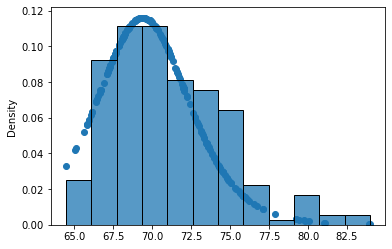

In [143]:
plt.scatter(test_per_pmt[:], np.exp(logpdf.detach().numpy()))
sns.histplot(test_per_pmt[:], stat="density")

In [34]:
labels, features = next(iter(dl))

ValueError: Shape of passed values is (2, 5126), indices imply (2, 2)

In [9]:
pdf=jammy_flows.pdf("e1", "gggg")

<KeysViewHDF5 ['dataset_1', 'dataset_10', 'dataset_11', 'dataset_12', 'dataset_2', 'dataset_3', 'dataset_4', 'dataset_5', 'dataset_6', 'dataset_7', 'dataset_8', 'dataset_9']>

In [29]:
with h5py.File("../assets/photon_table.hd5") as hdl:
    print(hdl["photon_tables/dataset_1"][:, 0])

[ 1.       66.140045]
